<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h2>Mixture Density Networks (MDN) for distribution and uncertainty estimation </h2>

This material is copyright Axel Brando and made available under the Creative Commons Attribution-ShareAlike 4.0 International License (http://creativecommons.org/licenses/by-sa/4.0/). Code is also made available under the Apache Version 2.0 License (https://www.apache.org/licenses/LICENSE-2.0). 

Please, to use this material and code follow the instructions explained in the main repository [https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation](https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation#bibtex-reference-format-for-citation)

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>3D Regression problem</h3>

In [2]:
import tensorflow as tf
tf.python.control_flow_ops = tf

#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.Session(config=config)

from keras.models import Sequential,Graph
from keras.layers.core import Dense, Dropout
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.models import model_from_json
from keras.regularizers import l2, activity_l2

from keras import backend as K

import numpy as np

Using TensorFlow backend.


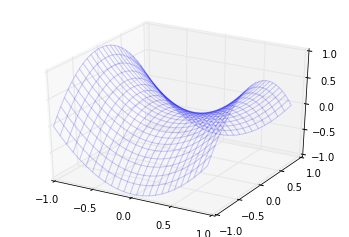

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import ListedColormap

x = np.arange(-1, 1, 0.08)
y = np.arange(-1, 1, 0.08)
x, y = np.meshgrid(x, y)
z = x**2 - y**2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, alpha=0.2)

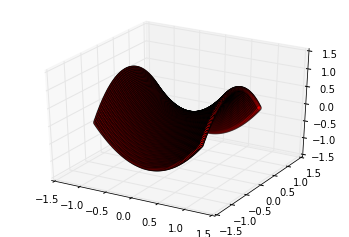

In [9]:
#Real z = (x²-y²) figure
def build_toy_dataset(N):
    x_data = np.array([(2*i/float(N))-1 for i in range(0, N) for j in range(0, N)])#[i for i in range(-1, 1, 0.1) for j in range(-1, 1, 0.1)]#np.float32(np.random.uniform(-1, 1, N))
    y_data = np.array([(2*j/float(N))-1 for i in range(0, N) for j in range(0, N)])#np.arange(-1, 1, 0.1)#np.float32(np.random.uniform(-1, 1, N))
    z_data = +x_data**2-y_data**2
    return x_data,y_data,z_data


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_data,y_data,z_data = build_toy_dataset(100)
ax.scatter(x_data,y_data,z_data, c='r', marker='o')
plt.show()

In [101]:
x_data,y_data,z_data = build_toy_dataset(1000)

In [103]:
def unison_shuffled_copies(a, b,c):
    assert len(a) == len(b)
    assert len(a) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

In [104]:
x_data,y_data,z_data = unison_shuffled_copies(x_data,y_data,z_data)

In [106]:
import tensorflow as tf
tf.python.control_flow_ops = tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from keras.models import Sequential,Graph
from keras.layers.core import Dense, Dropout
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.models import model_from_json
from keras.regularizers import l2, activity_l2

from keras.objectives import mean_absolute_error

from keras import backend as K

import numpy as np

c = 2 #The number of outputs we want to predict
m = 24 #The number of distributions we want to use in the mixture

#Note: The output size will be (c + 2) * m

from keras.layers.advanced_activations import ELU
def elu_modif(x, a=1.):
    return ELU(alpha=a)(x)+1.+1e-8

def log_sum_exp(x, axis=None):
    """Log-sum-exp trick implementation"""
    x_max = K.max(x, axis=axis, keepdims=True)
    return K.log(K.sum(K.exp(x - x_max), 
                       axis=axis, keepdims=True))+x_max


def mean_log_Gaussian_like(y_true, parameters):
    """Mean Log Gaussian Likelihood distribution
    Note: The 'c' variable is obtained as global variable
    """
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    alpha = components[:, c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-8,1.))
    
    exponent = K.log(alpha) - .5 * float(c) * K.log(2 * np.pi) \
    - float(c) * K.log(sigma) \
    - K.sum((K.expand_dims(y_true,2) - mu)**2, axis=1)/(2*(sigma)**2)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res


def mean_log_LaPlace_like(y_true, parameters):
    """Mean Log Laplace Likelihood distribution
    Note: The 'c' variable is obtained as global variable
    """
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    alpha = components[:, c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-2,1.))
    
    exponent = K.log(alpha) - float(c) * K.log(2 * sigma) \
    - K.sum(K.abs(K.expand_dims(y_true,2) - mu), axis=1)/(sigma)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res


graph = Graph()
graph.add_input(name='input', input_shape=(1,))
graph.add_node(Dense(24, activation='relu'), name='dense1_1', input='input')
graph.add_node(Dropout(0.25), name='drop1_1', input='dense1_1')

graph.add_node(Dense(output_dim=c*m), name='FC_mus', input='drop1_1')
graph.add_node(Dense(output_dim=m, activation=elu_modif), name='FC_sigmas', input='drop1_1') #K.exp, W_regularizer=l2(1e-3)
graph.add_node(Dense(output_dim=m, activation='softmax'), name='FC_alphas', input='drop1_1')
graph.add_output(name='output', inputs=['FC_mus','FC_sigmas', 'FC_alphas'], merge_mode='concat',concat_axis=1)
graphADV = graph
graph.compile('rmsprop', {'output':mean_log_likeG})

In [107]:
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
lossHistory = LossHistory()

In [ ]:
from datetime import datetime
start_time = datetime.now()
epoch=1000

graph.fit(data={'input':x_data,'output':np.array(zip(y_data,z_data))}, batch_size=100000, nb_epoch=epoch, 
          validation_split=0.1,callbacks=[lossHistory], verbose=1) #[np.tile(y,(1,c*m)),y] 
end_time = datetime.now()
a=0
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

In [113]:
def build_toy_dataset(N):
    x_data = np.array([(2*i/float(N))-1 for i in range(0, N) for j in range(0, N)])#[i for i in range(-1, 1, 0.1) for j in range(-1, 1, 0.1)]#np.float32(np.random.uniform(-1, 1, N))
    y_data = np.array([(2*j/float(N))-1 for i in range(0, N) for j in range(0, N)])#np.arange(-1, 1, 0.1)#np.float32(np.random.uniform(-1, 1, N))
    z_data = +x_data**2-y_data**2
    return x_data,y_data,z_data

x_data_val,y_data_val,z_data_val = build_toy_dataset(100)

In [120]:
parameters = graph.predict(data={'input':x_data_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

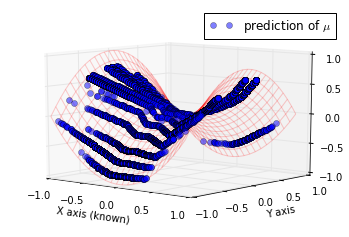

In [147]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

dim = alpha_pred.shape[1]

yz_pred = np.array([mu_pred[i,:,np.random.choice(dim,p=alpha_pred[i])] 
                    for i in np.arange(len(alpha_pred))])


ax.plot(x_data_val,yz_pred[:,0], yz_pred[:,1], 
        linestyle="None", marker="o",c='blue', 
        label='prediction of $\mu$', alpha=0.5)

ax.view_init(10, -50)

ax.legend()

x = np.arange(-1, 1, 0.08)
y = np.arange(-1, 1, 0.08)
x, y = np.meshgrid(x, y)
z = x**2 - y**2
ax.plot_wireframe(x, y, z, alpha=0.2, color='r')
ax.set_xlabel('X axis (known)')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')